In [1]:
%matplotlib inline
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')


# NIDS analysis on SVC

NIDS result generated to understand the score and the true and false positive rate a Receiver Operating Characteristic (ROC) metric was calculated on each of the classes to evaluate classifier output quality.

the scoring mechnisim was based on the training, validation test set
The ROC curves features the true positive rate on the Y axis, and false
positive rate on the X axis. This means that the top left corner of the plot is
the "ideal" point - a false positive rate of zero, and a true positive rate of
one. This mean that a larger area under the curve (AUC) is usually better.


In [2]:
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import label_ranking_loss
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

In [3]:
# import dataset into colab
%store -r IMBALANCED_TRAIN_VAL 
%store -r RESAMPLED_TRAIN_VAL 
%store -r TEST 
imbalanced_train=IMBALANCED_TRAIN_VAL.copy()
resampled_train= RESAMPLED_TRAIN_VAL.copy()
test= TEST.copy()
# imbalanced_train=imbalanced_train.head(500)
# test=test.head(500)

In [4]:
# Drop unwanted  columns
print(imbalanced_train.shape, 'imbalanced_train_val examples')
print(resampled_train.shape, 'resampled_train_val examples')
print(test.shape, 'test examples')
n_classes = test.shape[1]
print(n_classes)

(82332, 43) imbalanced_train_val examples
(370000, 43) resampled_train_val examples
(175341, 43) test examples
43


In [5]:
imbalanced_train.head(5)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,1,2,0,0,0,1,2,0,Normal
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,1,2,0,0,0,1,2,0,Normal
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,1,3,0,0,0,1,3,0,Normal
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,2,1,3,0,0,0,2,3,0,Normal
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,2,1,3,0,0,0,2,3,0,Normal


In [6]:
def group_dtype(data):
    # data=data.drop(columns=DROP_COL)
    columns=data.columns # get list of columns
    unique=data.dtypes.unique() # select one of each dtype
    result={'number_col':[],'string_category_col':[],'int_category_col':[],'labels':[]}
    for col in columns:
        if col=='attack_cat': 
            temp= result['labels'] # init array
        elif data[col].dtypes=='float64': 
            temp= result['number_col'] # init array
        elif data[col].dtypes=='int64':
             temp= result['int_category_col'] # init array
        else:
            temp= result['string_category_col'] # init array
        temp.append(col) # append the array
    return result

In [7]:
_col = group_dtype(imbalanced_train) # return result from
number_col=_col['number_col']
string_category_col=_col['string_category_col']
int_category_col=_col['int_category_col']

In [8]:
le = preprocessing.LabelEncoder()
def process_dataset(df):
    features=df.drop(['attack_cat'], axis=1)
    target=df['attack_cat']
#     sns.set(font_scale=3)
#     plt.figure(figsize=(60, 30))
#     sns.histplot(y=target)
#     plt.show()
    transformed_features=features.copy()
    for c in string_category_col:
        col = features[c]
        le.fit(col)
        transform_col= le.transform(col)
        transformed_features[c]=transform_col
    le.fit(target)
    transformed_target=le.transform(target)
    transformed_target = label_binarize(transformed_target, classes=[0,1,2,3,4,5,6,7,8,9])
    return(transformed_features.values,transformed_target)

In [9]:
RESULTS={}
def ML(df_train,df_test, name):
    X,y=process_dataset(df_train)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)
    print(y_val.shape)
    X_test,y_test=process_dataset(df_test)
    n_classes = y_train.shape[1]
    print(n_classes)
    print("# #############################################################################")
    print("processing Classification and ROC analysis for: {}".format(name))
    print("________________________________________________________")
    clf = OneVsRestClassifier(SVC(kernel="sigmoid",gamma='auto', probability=True, random_state=42,verbose=True))
    print("________________________________________________________")
    pipe = make_pipeline(StandardScaler(), clf)
    y_score = pipe.fit(X_train, y_train).decision_function(X_val)
    train_score = pipe.score(X_train, y_train)
    val_score = pipe.score(X_val, y_val)
    test_score = pipe.score(X_test, y_test)
#     predict the training validation and the testing sets
    train_y_pred= pipe.predict(X_train)
    val_y_pred= pipe.predict(X_val)
    test_y_pred= pipe.predict(X_test)
#     loss calculation on training validation and the testing sets using label_ranking_loss
    train_loss=label_ranking_loss(y_train, train_y_pred)
    val_loss=label_ranking_loss(y_val, val_y_pred)
    test_loss=label_ranking_loss(y_test, test_y_pred)
# generating precisions and recall using precision_recall_curve
    train_precision, train_recall, _ = precision_recall_curve(y_train.ravel(), train_y_pred.ravel())
    val_precision, val_recall, _ = precision_recall_curve(y_val.ravel(), val_y_pred.ravel())
    test_precision, test_recall, _ = precision_recall_curve(y_test.ravel(), test_y_pred.ravel())
# #    compyling results 
    SCORES={}
    SCORES['train']={'loss':train_loss, 'accuracy':train_score,'precision':np.mean(train_precision),'recall':np.mean(train_recall)}
    SCORES['valdation']={'loss':val_loss, 'accuracy':val_score,'precision':np.mean(val_precision),'recall':np.mean(val_recall)}
    SCORES['test']={'loss':test_loss, 'accuracy':test_score,'precision':np.mean(test_precision),'recall':np.mean(test_recall)}
    RESULTS[name]=SCORES
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    lw = 2
        # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
    plt.figure(figsize=(10, 10), dpi=80)
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,)

    plt.plot(
                fpr["macro"],
                tpr["macro"],
                label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
                color="navy",
                linestyle=":",
                linewidth=4,
                    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue","darkorange","khaki","lime","darkgreen","hotpink","crimson","peru"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
                fpr[i],
                    tpr[i],
                    color=color,
                    lw=lw,
                    label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
                        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic to multiclass for: {}".format(name))
    plt.legend(loc="best")
    plt.show()
        


(16467, 10)
10
# #############################################################################
processing Classification and ROC analysis for: ML-IMBALANCED
________________________________________________________
________________________________________________________
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

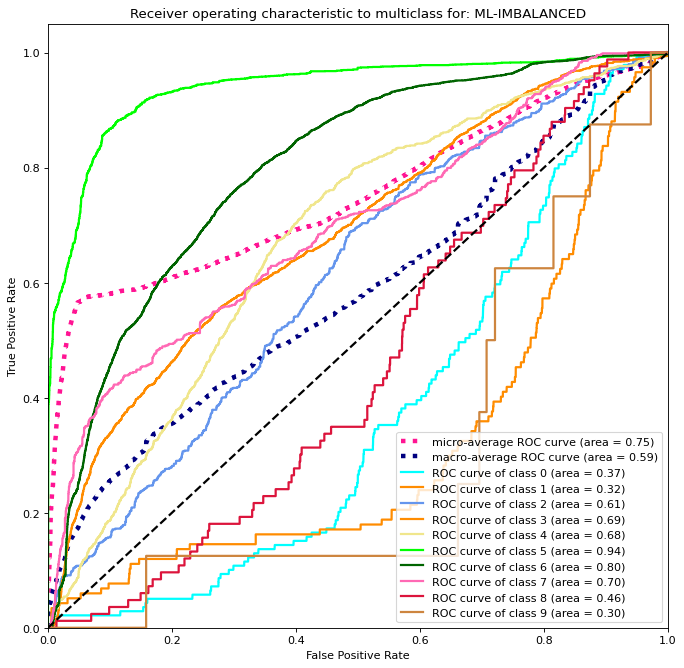

In [10]:
df_train= imbalanced_train.copy()
df_test= test.copy()
ML(df_train,df_test,'ML-IMBALANCED')

In [14]:
print(RESULTS)
# IMBALANCED_SCORES=SCORES
# IMBALANCED_SCORES

{'ML-IMBALANCED': {'train': {'loss': 0.4494395101090615, 'accuracy': 0.4913687087223867, 'precision': 0.5591303988299198, 'recall': 0.5217996406791671}, 'valdation': {'loss': 0.4576290628394836, 'accuracy': 0.4833910244731888, 'precision': 0.5590445045384986, 'recall': 0.5190988036679419}, 'test': {'loss': 0.47523080422972636, 'accuracy': 0.4982747902658249, 'precision': 0.558058008604541, 'recall': 0.5100860608756651}}}


(74000, 10)
10
# #############################################################################
processing Classification and ROC analysis for: ML-BALANCED
________________________________________________________
________________________________________________________
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

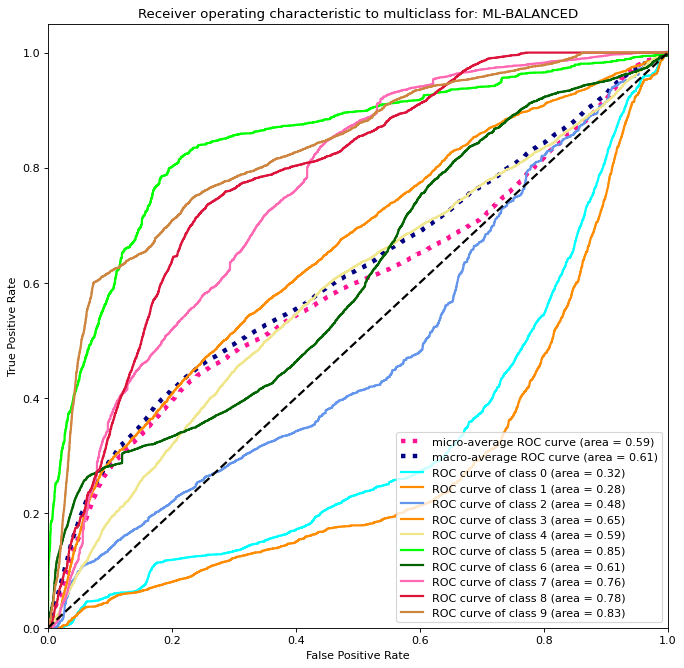

In [15]:
df_train= resampled_train.copy()
df_test= test.copy()
ML(df_train,df_test,'ML-BALANCED')

In [16]:
# store result in a file for evaluation process
import pickle
# Step 2
with open('SVM_ML_RESULTS.dictionary', 'wb') as result_dictionary_file:
    pickle.dump(RESULTS, result_dictionary_file)